# Homework #4 Part I: Fit this model using HMC in `PyMC`

For the model specification example considered in "Metropolis within Gibbs" above...


## Provide posterior analysis for this model using "default" `PyMC`

- Don't try to do "Metropolis within Gibbs" `in PyMC` -- you can't -- use the default HMC sampler
- You can do this without knowing what HMC is: you've already previously used HMC with `PyMC`; and, you can go get the distributions you need [here...](https://www.pymc.io/projects/docs/en/stable/api/distributions.html)
- ***Explore and describe the sample sizes needed to support inference regarding the `df` parameter $(\nu)$***

*Ahem...*

- Is it eating you up inside that you don't know what HMC actualy is?
- Do you hate just using something without knowing what it is?<br>Or what you're even doing when you use it?

*Well then, my friends, have I got the cure for you!*<br>All **you** must **do** is listen **to** someone **who** will re**view** for **you** the next slides **few**!

In [16]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats

In [ ]:
mu_0,sigma_0=0,10
n, loc_true, scale_true, df_true = 100, 10, 2, 15
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

with pm.Model() as model:
    loc = pm.Normal('loc', mu=mu_0, sigma=sigma_0)
    scale = pm.HalfNormal('scale', sigma=5)
    df = pm.DiscreteUniform('df', lower=1, upper=100)

    likelihood = pm.StudentT('x', mu=loc, sigma=scale, nu=df, observed=x)
    trace = pm.sample(1000, return_inferencedata=True)

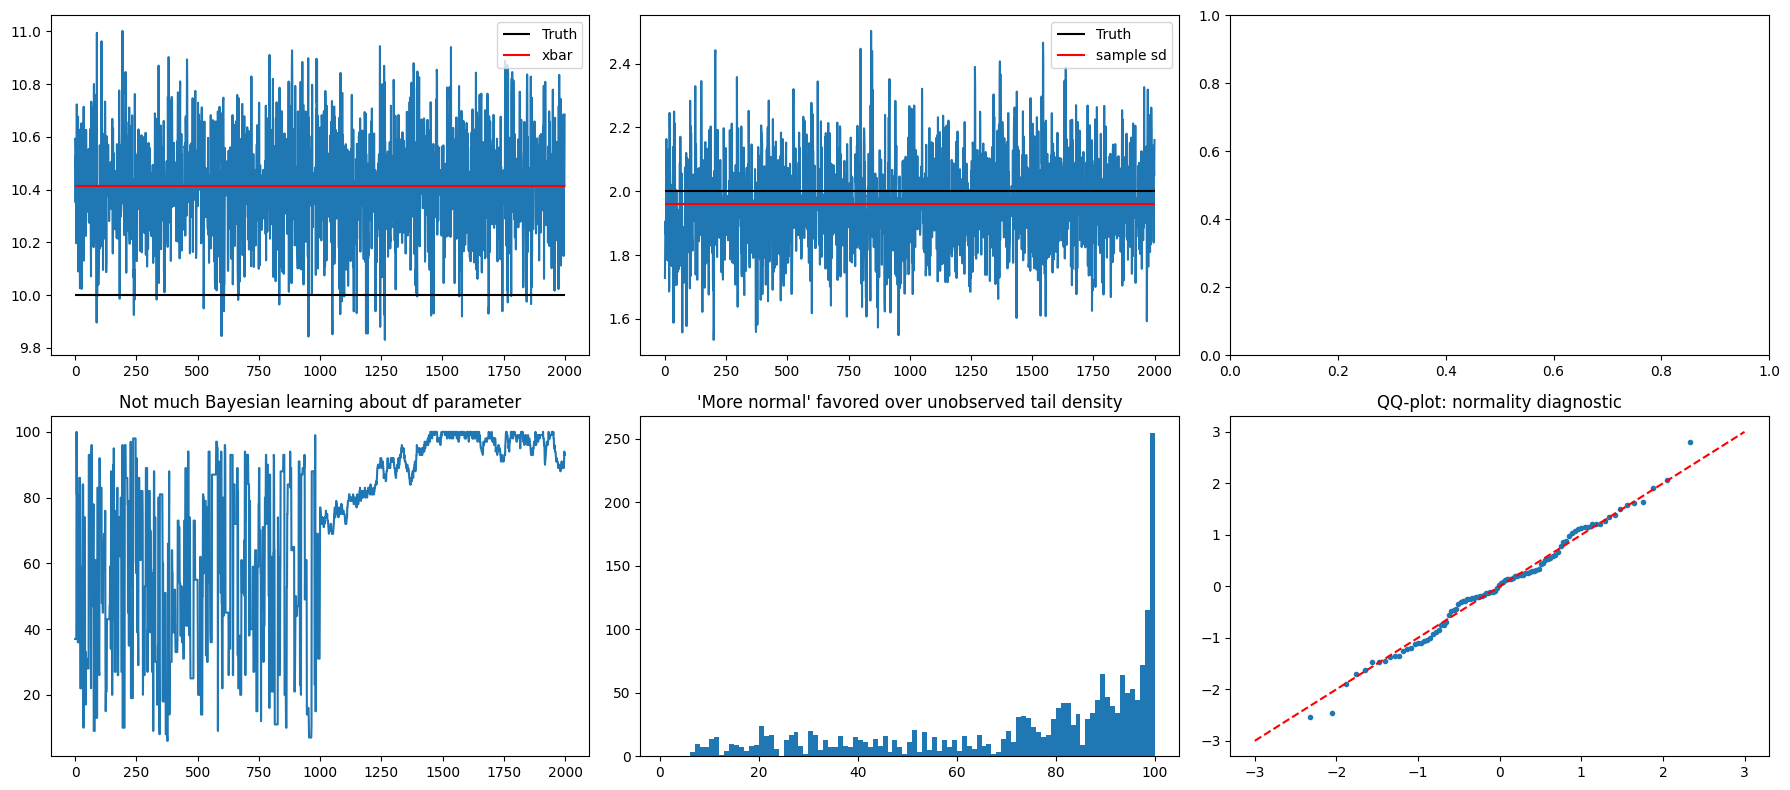

In [ ]:
loc_samples = trace.posterior['loc'].values.flatten()
scale_samples = trace.posterior['scale'].values.flatten()
df_samples = trace.posterior['df'].values.flatten()

fig, ax = plt.subplots(2, 3, figsize=(18, 8))

# Location
ax[0, 0].plot(loc_samples)
ax[0, 0].hlines(loc_true, xmin=0, xmax=len(loc_samples), label='Truth', color='black')
ax[0, 0].hlines(x.mean(), xmin=0, xmax=len(loc_samples), label='xbar', color='red')
ax[0, 0].legend()

# Scale
ax[0, 1].plot(scale_samples)
ax[0, 1].hlines(scale_true, xmin=0, xmax=len(scale_samples), label='Truth', color='black')
ax[0, 1].hlines(x.std(), xmin=0, xmax=len(scale_samples), label='sample sd', color='red')
ax[0, 1].legend()

# Degrees of Freedom
ax[1, 0].plot(df_samples)
ax[1, 1].hist(df_samples, bins=range(1, 101))
ax[1, 0].set_title("Not much Bayesian learning about df parameter")
ax[1, 1].set_title("'More normal' favored over unobserved tail density")

# QQ-plot
qq = stats.norm.ppf(np.linspace(0.01, 0.99, n))
x_sorted_normed = np.sort((x - np.mean(x)) / np.std(x))
ax[1, 2].plot(qq, x_sorted_normed, '.')
ax[1, 2].plot([-3, 3], [-3, 3], 'r--')
ax[1, 2].set_title("QQ-plot: normality diagnostic")

plt.tight_layout()
plt.show()

# Homework #4 Part II: HMC Diagnostics

- Return to your posterior analysis in "Homework #4 Part I" and
report on (a) ***effective sample sizes***; (b) ***chain convergence measures***; (c) ***divergences***; (d) ***Metropolis-Hastings acceptance rates*** [see below for how to access these]; and (e) any other warnings or concers provided by `PyMC`

- Now examine the [Eight Schools](https://github.com/pointOfive/STA410_W24_StatisticalComputation/blob/main/Week3/STA410_W24_Week3_Demo_HMCwithPyMC.ipynb) example PyMC model and outputted results
    - Provide an analogous report regarding (a)-(e) above for the "centered" and "uncentered" Eight Schools models
        - *Hint: for (d) see `fit_C.sample_stats.acceptance_rate.values.flatten()` and `fit_NC.sample_stats.acceptance_rate.values.flatten()` and in the Eight Schools example*
    - From the perspective of ***curvature*** of the ***energy function*** (that is, how rapidly the ***log joint posterior distribution density*** changes for different values of its ***random variable (parameters)*** and the effectiveness of the ***HMC*** algorithm, explain why the "uncentered" paramterization of the model performs better than the "centered" parameterization
        - *Hint: see the previous two slides...*
- Review [this](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#model-checking) and [that](https://discourse.pymc.io/t/about-nuts-sampling-and-energy-plot/831) discussing the ***diagnostic plot*** which compares the ***observed energy proposal distribution*** versus the ***empirical energy distribution*** of the generated HMC samples
    - Use the code on the next slide to provide and interpret the ***diagnostic plot*** assessing ***energy proposals*** versus the empirical ***energy*** distribution to compare and contrast the "centered" and "uncentered" Eight Schools models in relation to you previous comparision of these two model parameterization in terms of ***energy function curvature*** and the effectiveness of the ***HMC*** algorithm... does this diagnostic support your previous conclusions in these regards?




In [ ]:
import pymc as pm
import numpy as np
import arviz as az

# Data for the Eight Schools model
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as Centered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=[20100420, 20134234])
with pm.Model() as NonCentered_eight:
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=[20100420, 20134234])
# Effective sample sizes
ess_C = az.ess(fit_C)
ess_NC = az.ess(fit_NC)

# Chain convergence measures (R-hat)
rhat_C = az.rhat(fit_C)
rhat_NC = az.rhat(fit_NC)

# Divergences
divergences_C = fit_C.sample_stats.diverging.sum().item()
divergences_NC = fit_NC.sample_stats.diverging.sum().item()

# Metropolis-Hastings acceptance rates
acceptance_rate_C = fit_C.sample_stats.acceptance_rate.values.flatten()
acceptance_rate_NC = fit_NC.sample_stats.acceptance_rate.values.flatten()

# Energy plot comparison
az.plot_energy(fit_C)
az.plot_energy(fit_NC)
